In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def aggregating_algorithm(gammas, omegas, eta=2.0, C_eta=1.0, weights=None):
    """
    Calculates predictions produced by the Aggregating Algorithm w/ Specialist Experts (AAS) using the square-loss (Brier's) game.

    Parameters:
    - gammas (np.array): a matrix of predictions, where each row is a sequence of experts' predicitons for that time step
    - omegas (np.array): an array of observed outcomes
    - eta (float): a learning rate to control how quickly the algorithm updates an expert's weight
    - C_eta (float): a scale parameter associated with \eta to control the aggressiveness of weight updates
    - weights (np.array): an array of initial weights for each expert

    Returns:
    - cumulative_experts_losses (np.array): a matrix of losses, where each column is the cumulative loss of an expert at each time step
    - cumulative_learner_losses (np.array): an array of the learner's cumulative loss at each time step
    """
    N, T = gammas.T.shape

    experts_losses = np.array([np.zeros(N)])
    learner_loss = np.zeros(T)
    cumulative_experts_losses = np.array([np.zeros(N)])
    cumulative_learner_loss = np.zeros(T + 1)

    # Step 1: Initialise weights, w^i_0 = q_i, i = 1, 2, ..., N
    if not weights:
        weights = np.ones(N) / N

    # Step 2: Repeat for t \in T...
    for t in range(T):
        # Step 3: Read the experts' predictions \gamma^n_t of awake experts
        gammas_t = gammas[t, :]

        # Maintain a list of awake experts
        awake_experts = ~np.isnan(gammas_t)

        # If there are no awake experts for a timestep, skip the iteration
        if not any(awake_experts):
            continue

        # Step 4: Normalise the weights of awake experts
        normalised_weights = weights[awake_experts] / np.sum(weights[awake_experts])

        # Step 5: Solve the system (\omega \in \Omega)
        generalised_prediction = -(C_eta / eta) * np.log(
            np.sum(
                normalised_weights
                * np.exp(
                    -eta
                    * np.array(
                        [
                            (omega_t - gamma_t) ** 2
                            for omega_t in [0, 1]
                            for gamma_t in gammas_t[awake_experts]
                        ]
                    ).reshape(2, np.sum(awake_experts))
                ),
                axis=1,
            )
        )

        # Calculate the learner's prediction
        gamma_t = (1 / 2) - (
            (generalised_prediction[1] - generalised_prediction[0]) / 2
        )

        # Step 6: Observe the outcome \omega_t
        omega_t = omegas[t]

        # Calculate the awake experts' losses
        awake_losses = np.array(
            [(omega_t - gamma_t) ** 2 for gamma_t in gammas_t[awake_experts]]
        )

        # Calculate the learner's and asleep experts' loss
        loss = (omega_t - gamma_t) ** 2
        losses = np.full(awake_experts.shape, loss)
        losses[awake_experts] = awake_losses

        experts_losses = np.vstack((experts_losses, losses))
        learner_loss[t] = loss
        cumulative_experts_losses = np.cumsum(experts_losses, axis=0)
        cumulative_learner_loss[t + 1] = cumulative_learner_loss[t] + learner_loss[t]

        # Step 7: Update the awake experts' weights w^n_t = w^n_{t-1} e^{-\eta \lambda(\gamma^n_t, \omega)}
        weights[awake_experts] *= np.exp(-eta * losses[awake_experts])

        # Step 8: Update the sleeping experts' weights w^n_t = w^n_{t-1} e^{\frac{-\eta\lambda(\gamma_t, \omega)}{C(\eta)}}
        weights[~awake_experts] *= np.exp((-eta * losses[~awake_experts]) / C_eta)

        # Renormalise the updated experts' weights.
        weights = weights / np.sum(weights)

    return (cumulative_experts_losses, cumulative_learner_loss)

In [3]:
filename = "sleeping_expert_test.txt"

gammas = np.empty((0, 4), dtype=float)

with open(filename, "r") as file:
    for line in file:
        columns = line.strip().split()
        values = np.array([float(columns[i]) for i in range(3, len(columns), 2)])
        gammas = np.vstack((gammas, values))

omegas = np.ones(gammas.shape[0])

(cumulative_experts_losses, cumulative_learner_loss) = aggregating_algorithm(
    gammas, omegas
)

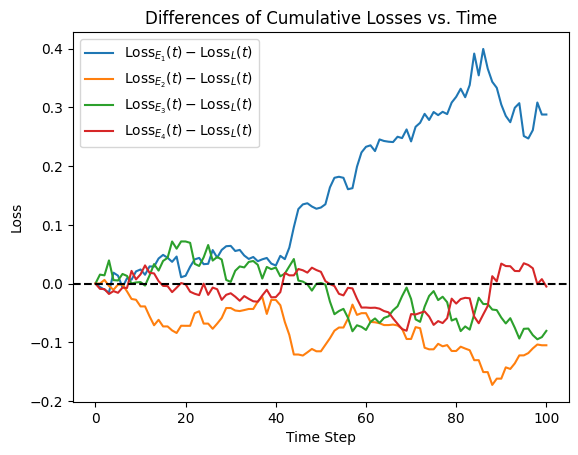

In [4]:
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 0] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_1}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 1] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_2}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 2] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_3}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 3] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_4}(t) - \\text{Loss}_L(t)$",
)
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Differences of Cumulative Losses vs. Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.legend()
plt.show()